In [ ]:

# import libraries needed
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, skew, probplot
import warnings

In [ ]:
#read in the data file
track_df = pd.read_csv("dataset.csv")

In [ ]:
#rows and columns of table
track_df.shape

In [ ]:
#number of categorical variables
cat_num = 0
for dtype in track_df.dtypes:
    if dtype == "object":
        cat_num = cat_num + 1

In [ ]:
print("# of categorical variables:", cat_num)

#rest of the columns are numeric
numeric_vars = track_df.shape[1] - cat_num - 2 #subtract 2 columns for number and track id columns
print("# of numeric variables:", numeric_vars) 

In [ ]:
track_df.head()

Handle Missing Data

In [ ]:
#remove the unnamed 'order' column
track_df = track_df.drop(columns=["Unnamed: 0","album_name","track_name","artists"])
# missing data
total = track_df.isnull().sum().sort_values(ascending=False)
percent = (track_df.isnull().sum() / track_df.isnull().count()).sort_values(
    ascending=False
)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data.head(20)

Since we do not need to worry about missing album names, track names, or artist names, nothing needs to be changed here. 

In [ ]:
# We are checking to see if any columns are largely homogeneous
# Homogeneous columns provide no value to our model and can sometimes lead to overfitting
print("Categorical Columns Mode Frequency")

cat_columns = track_df.select_dtypes(include=["object"]).columns

mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])

for col in cat_columns:
    mode_value = track_df[col].mode().values[0]
    mode_freq = (track_df[col] == mode_value).mean()
    row_data = pd.DataFrame([{"column_name": col, "mode_frequency": mode_freq}])
    mode_freq_df = pd.concat([mode_freq_df,row_data], ignore_index= True)
mode_freq_df.sort_values("mode_frequency", ascending=False).head(10)

Almost no Homogeneity within this dataset, so there is nothing to filter out!

In [ ]:
# Check remaining missing values if any
all_data_na = track_df.isnull().sum() / len(track_df)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(
    ascending=False
)
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head()

Handling non 0-1 range values:
certain columns (i.e tempo, loudness) have values that are not within a [0,1] range. We will use minmax scaling to bring it to a [0,1] range

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Reshape the 'tempo' and 'loudness' column to a 2D array as required by MinMaxScaler
tempo_values = track_df['tempo'].values.reshape(-1, 1)

loudness_values = track_df['loudness'].values.reshape(-1,1)
# Fit the scaler to the tempo and loudness values and transform them
scaled_tempo = scaler.fit_transform(tempo_values)
scaled_loudness = scaler.fit_transform(loudness_values)


# Replace the original 'tempo' and 'loudness' column with the scaled values
track_df['tempo'] = scaled_tempo
track_df['loudness'] = scaled_loudness
# Now the 'tempo' and 'loudness' column values are scaled between 0 and 1

Handling Outliers

Make 'general' genres using NLP models and K-mean

In [83]:
!pip3 install spacy

  Using cached cymem-2.0.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 19.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.4/486.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 27.4 MB/s eta 0:00:00
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.2 MB/s eta 0:00:00
Using cached setupt

In [89]:

import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load spaCy's pre-trained word vectors model
nlp = spacy.load("en_core_web_md")

# Step 1: Collect genre names
genre_names = track_df['track_genre'].unique()

print(genre_names)

genre_mappings = {
    'Acoustic': ['acoustic'],
    'World Music': ['afrobeat', 'brazil', 'cantopop', 'french', 'forro', 'german', 'indian', 'iranian', 'j-dance', 'j-idol', 'j-pop', 'j-rock', 'k-pop', 'malay', 'mandopop', 'mpb', 'new-age', 'pagode', 'samba', 'sertanejo', 'spanish', 'swedish', 'tango', 'turkish', 'world-music'],
    'Rock': ['alt-rock', 'alternative', 'british', 'emo', 'goth', 'grunge', 'guitar', 'hard-rock', 'hardcore', 'indie', 'industrial', 'psych-rock', 'punk-rock', 'punk', 'rock-n-roll', 'rock', 'rockabilly'],
    'Blues': ['blues'],
    'Country': ['bluegrass', 'country', 'honky-tonk'],
    'Electronic': ['ambient', 'breakbeat', 'chicago-house', 'club', 'deep-house', 'detroit-techno', 'disco', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'garage', 'house', 'idm', 'progressive-house', 'techno', 'trance', 'trip-hop'],
    'Children': ['children', 'disney', 'kids'],
    'Classical': ['classical', 'opera', 'piano'],
    'Comedy': ['comedy'],
    'Reggae': ['dancehall', 'reggae', 'ska'],
    'Metal': ['black-metal', 'death-metal', 'grindcore', 'heavy-metal', 'metal', 'metalcore'],
    'Folk': ['folk', 'singer-songwriter', 'songwriter'],
    'Pop': ['anime', 'chill', 'dance', 'happy', 'pop-film', 'pop', 'power-pop', 'romance', 'sad', 'show-tunes'],
    'Funk': ['funk'],
    'Gospel': ['gospel'],
    'Jazz': ['jazz'],
    'R&B': ['r-n-b', 'soul'],
    'Latin': ['brazil', 'latin', 'latino', 'salsa'],
    'Hip-hop': ['hip-hop'],
    'Punk': ['punk', 'punk-rock'],
    'Techno': ['minimal-techno'],
    'Party': ['party'],
    'Sleep': ['sleep'],
    'Study': ['study']
}




['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

Get numerical cols first

In [ ]:
numerical_columns = []

for col, dtype in track_df.dtypes.items():
    if dtype == "float64":
        numerical_columns.append(col)

print("Numerical Columns:", numerical_columns)

Now plot those to see which may have outlier vals

/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_22152/2346888232.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


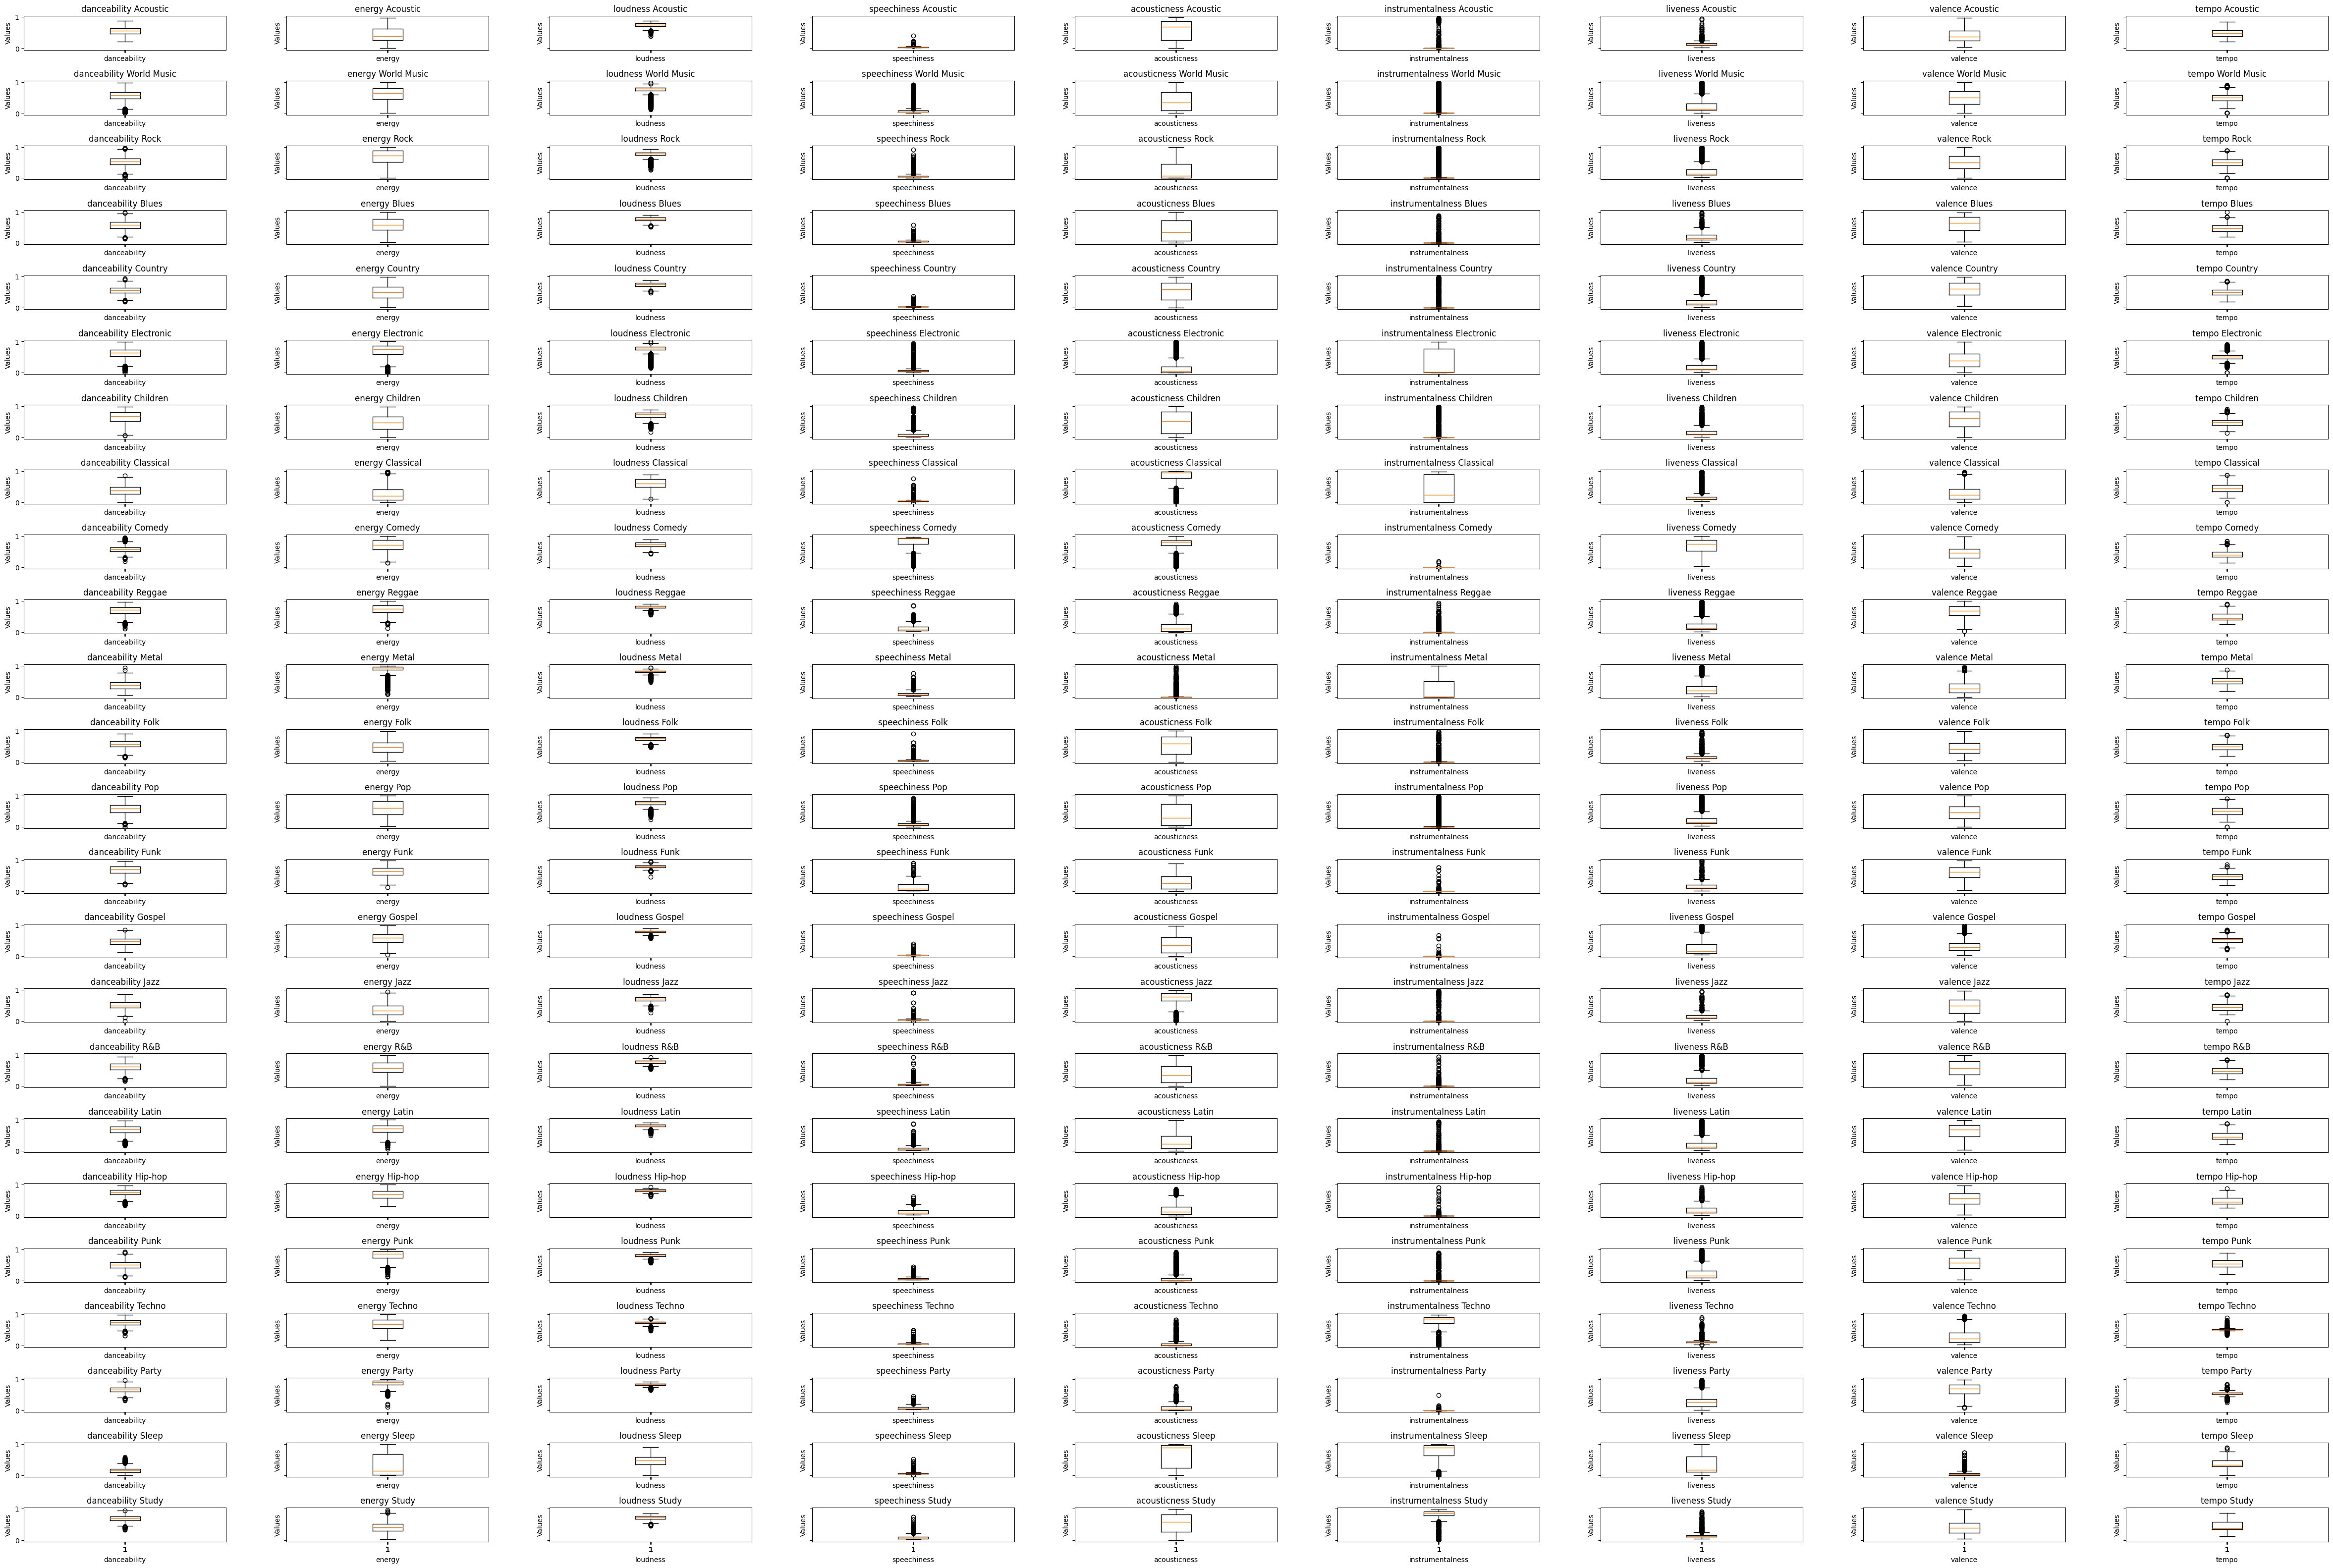

In [109]:

import matplotlib.pyplot as plt

# Define the number of rows and columns for subplots
num_rows = len(genre_mappings)
num_cols = len(numerical_columns)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(60, 40), sharex='col', sharey='row', 
                         gridspec_kw={'hspace': 0.9, 'wspace': 0.3})

# Iterate over each basic genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    # Iterate over each numerical column
    for j, col in enumerate(numerical_columns):
        # Box plot
        axes[i, j].boxplot(filtered_df[col])
        axes[i, j].set_title(f"{col} {basic_genre}")
        axes[i, j].set_xlabel(col)
        axes[i, j].set_ylabel("Values")

# Adjust layout
plt.tight_layout()
plt.show()


Lets graph the most irregular columns to their genre to see if there are many outliers, this can lead to overfitting. 

/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_22152/3492153562.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


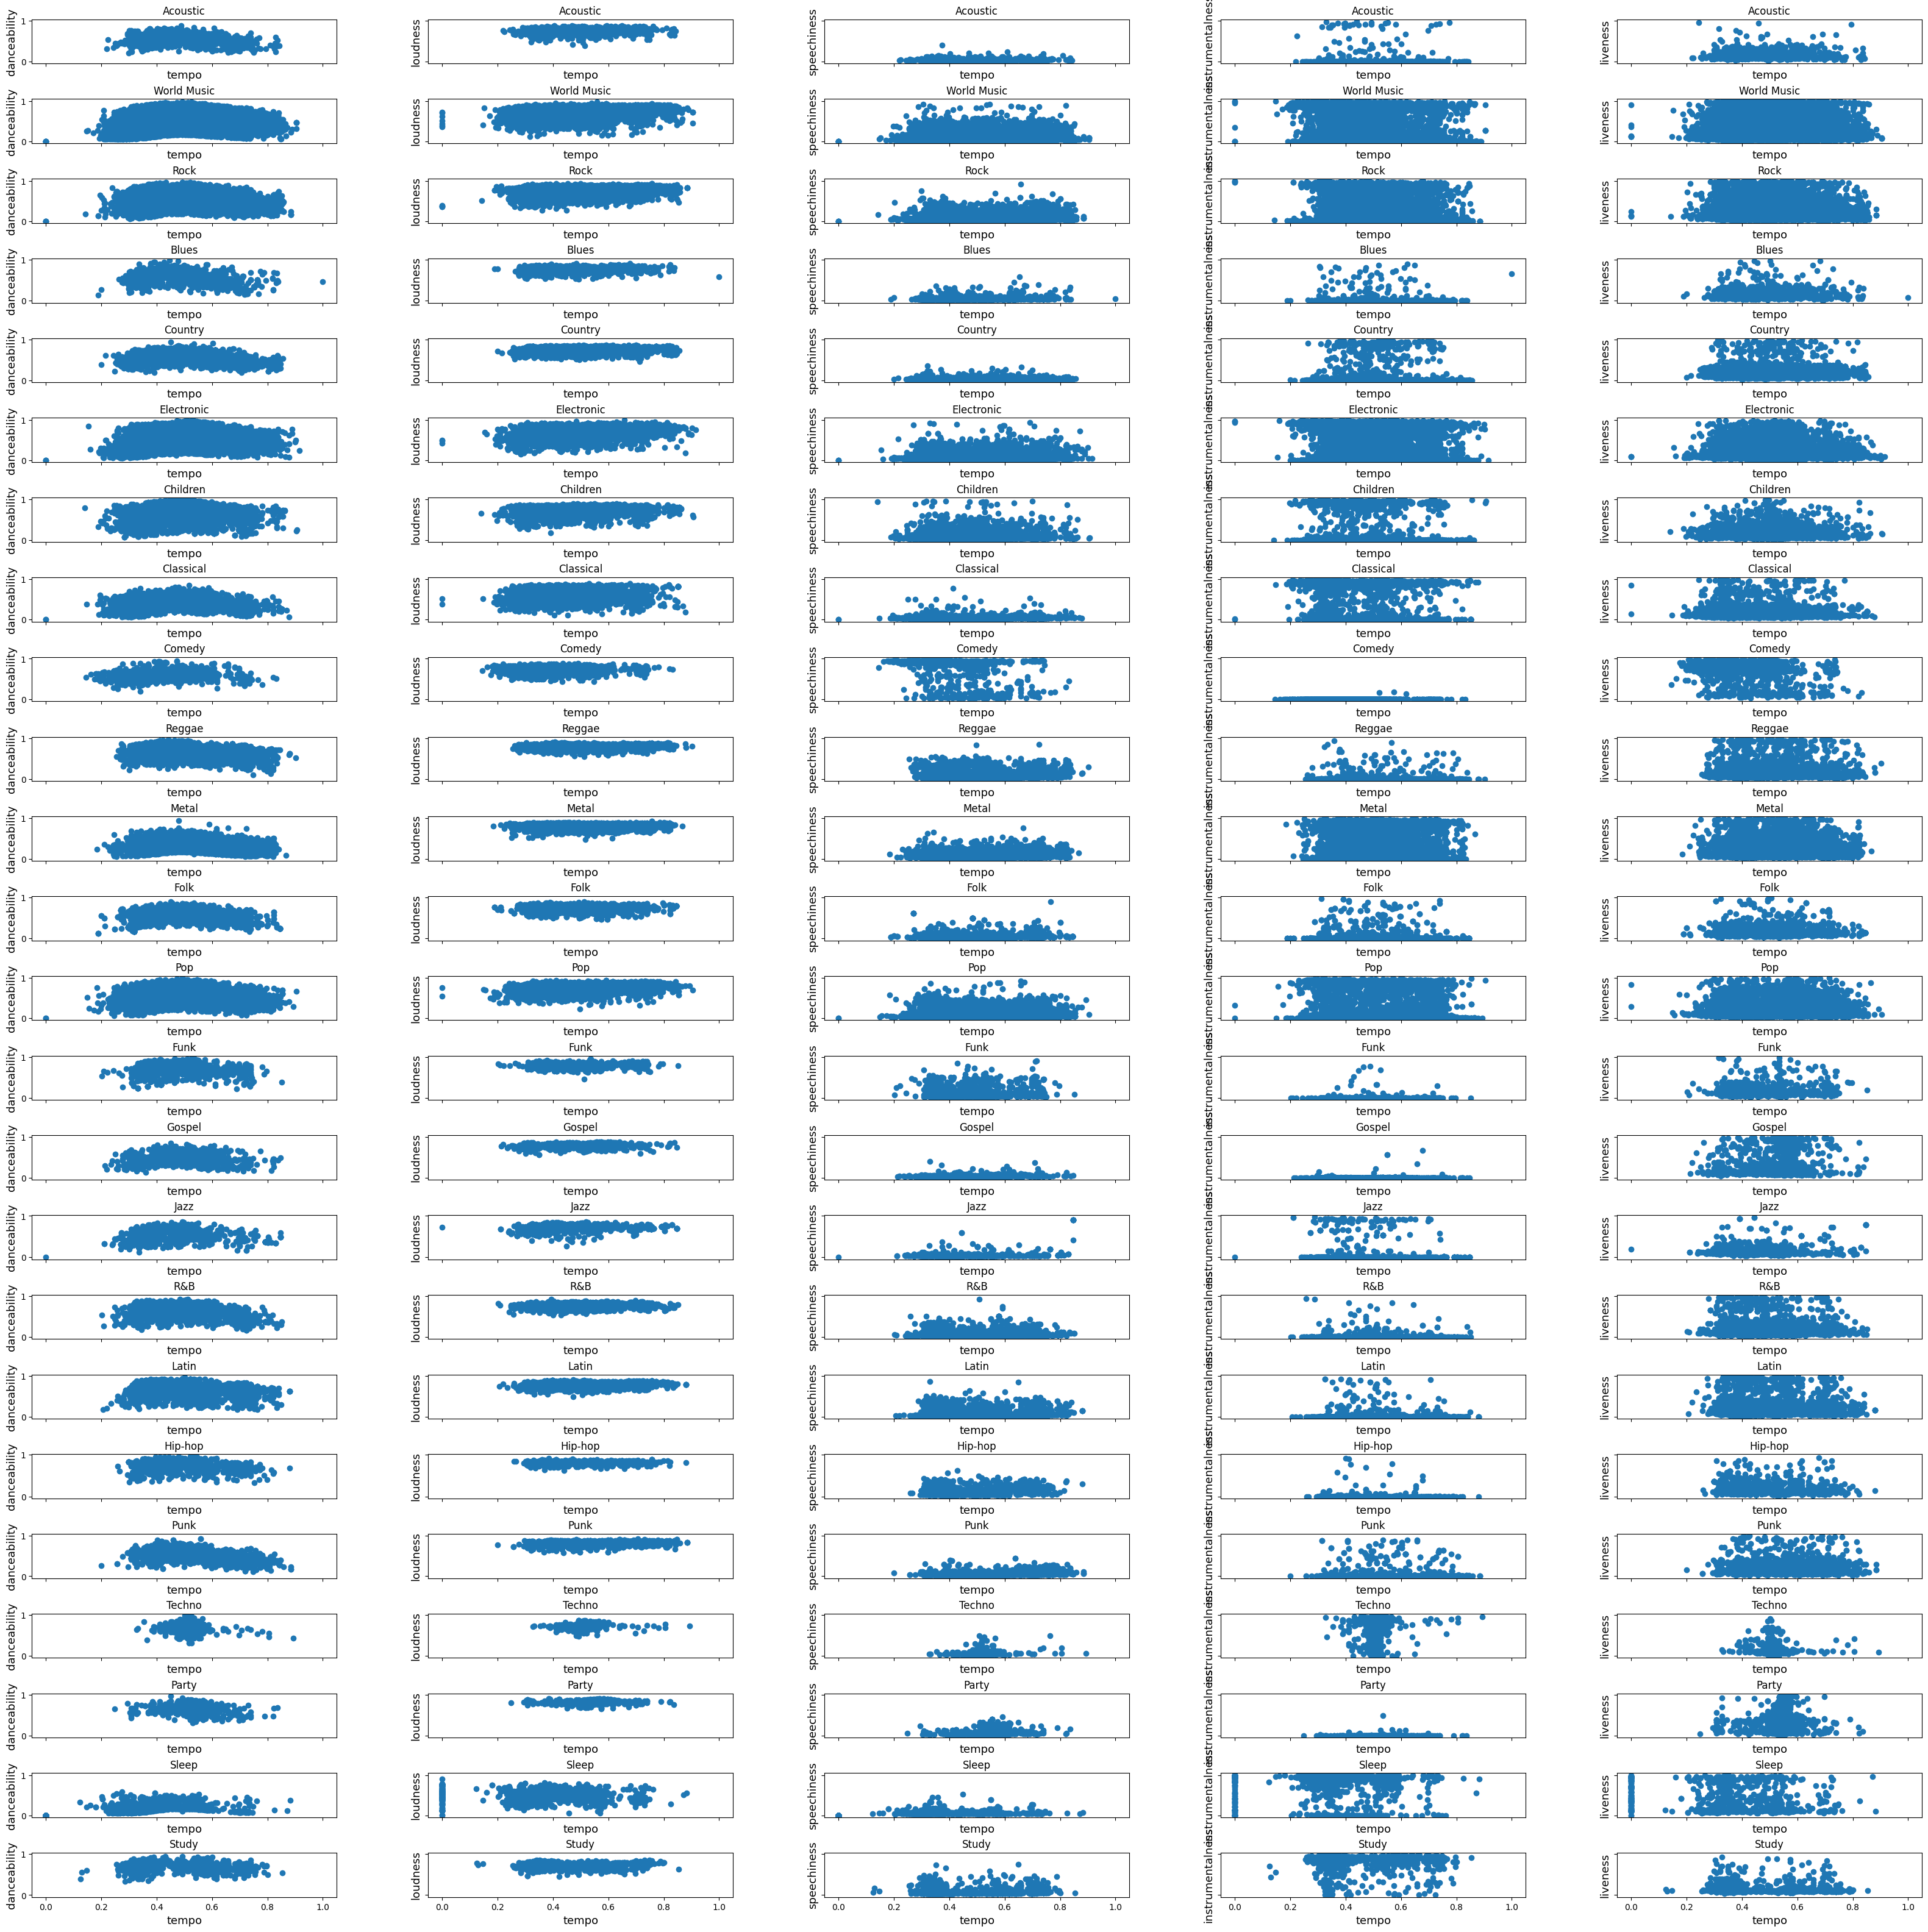

In [103]:
potential_outliers = ["danceability", "loudness", "speechiness", "instrumentalness", "liveness"]


# Define the number of rows and columns for subplots
num_rows = len(genre_mappings)
num_cols = len(potential_outliers)

# Create subplots with spacing
fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40), sharex='col', sharey='row', 
                         gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

# Iterate over each basic genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    # Iterate over each potential outlier column
    for j, col in enumerate(potential_outliers):
        # Scatter plot
        axes[i, j].scatter(x=filtered_df['tempo'], y=filtered_df[col])
        axes[i, j].set_title(f"{basic_genre}")
        axes[i, j].set_xlabel("tempo", fontsize=13)
        axes[i, j].set_ylabel(col, fontsize=13)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Define a function to remove outliers based on linear regression fit
def remove_outliers(df, x_col, y_col):
    # Fit linear regression model
    model = LinearRegression()
    model.fit(df[x_col].values.reshape(-1, 1), df[y_col].values)
    
    # Predict y values using the model
    y_pred = model.predict(df[x_col].values.reshape(-1, 1))
    
    # Calculate residuals (difference between actual and predicted y values)
    residuals = df[y_col].values - y_pred
    
    # Calculate absolute residuals
    abs_residuals = abs(residuals)
    
    # Find rows with absolute residuals within a threshold (adjust threshold as needed)
    threshold = 0.3  # Adjust threshold as needed
    inlier_mask = abs_residuals < threshold
    
    # Return DataFrame with outliers removed
    return df[inlier_mask]


/var/folders/d8/r30nz4q57b17kphtz7nm89b40000gn/T/ipykernel_22152/3318930775.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


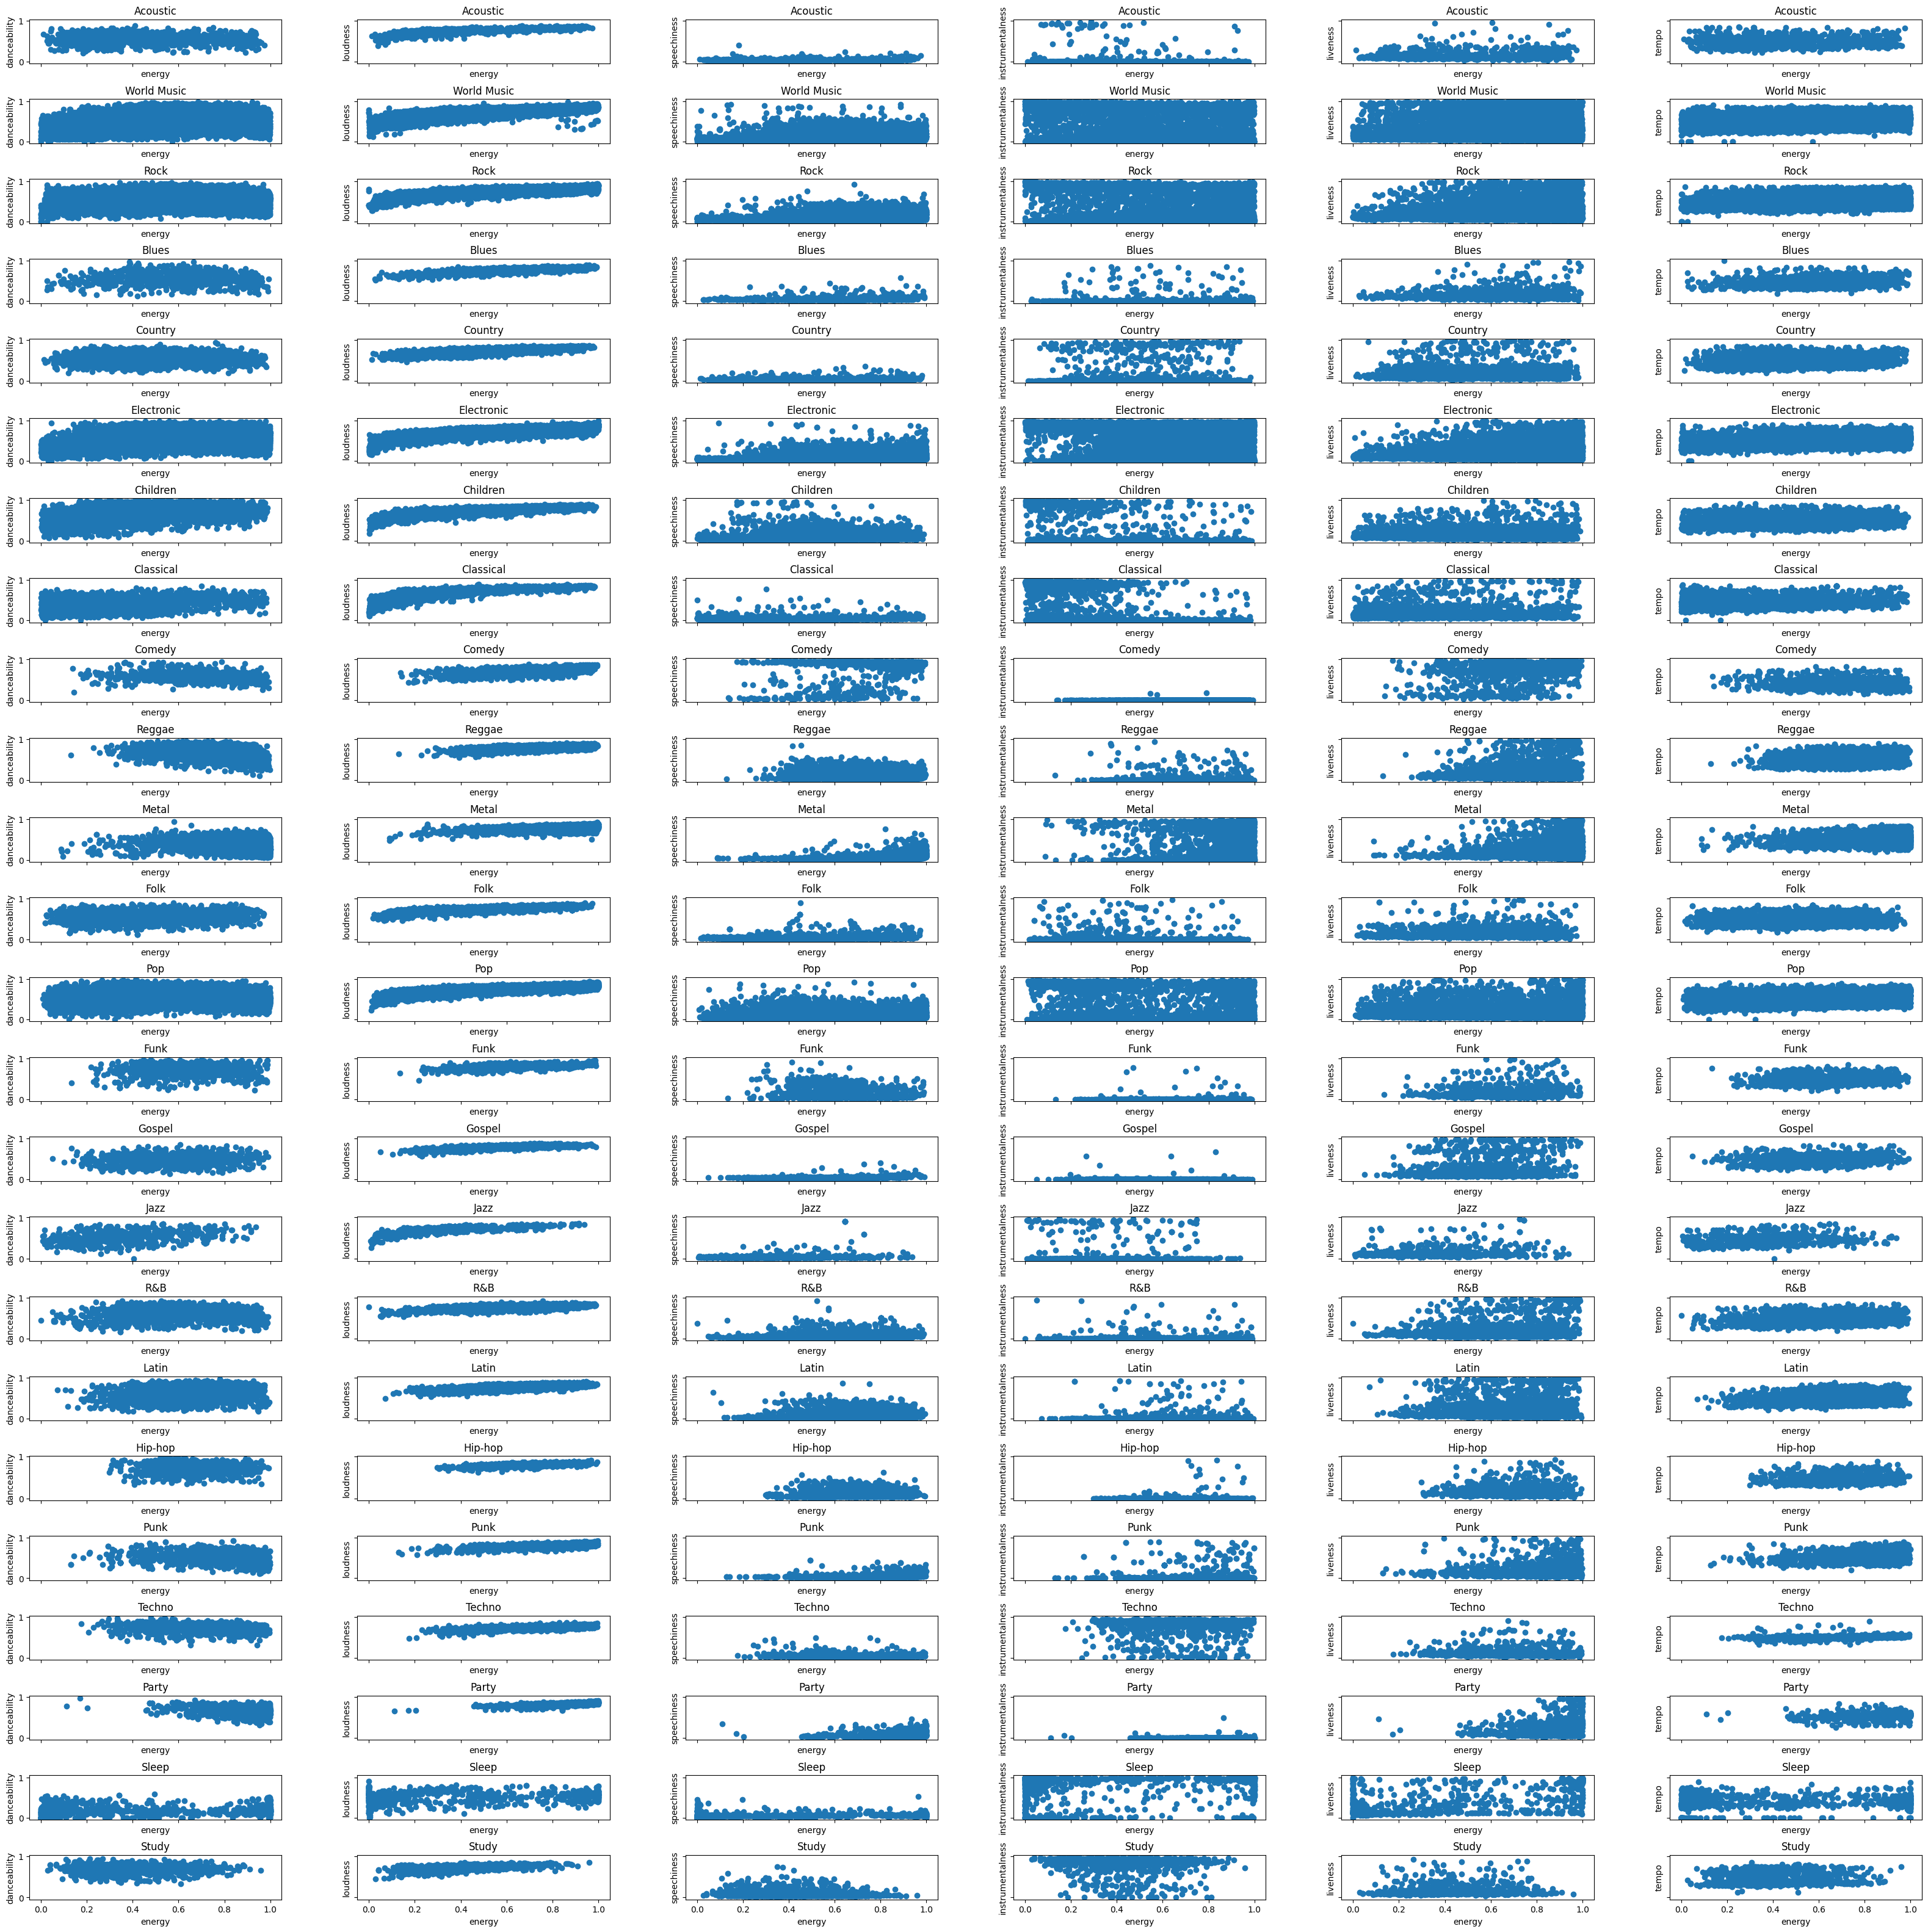

In [105]:
potential_outliers = ["danceability", "loudness", "speechiness", "instrumentalness", "liveness", "tempo"]
# Create subplots with spacing
# Define the number of rows and columns for subplots

num_cols = len(potential_outliers)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40), sharex='col', sharey='row', 
                         gridspec_kw={'hspace': 0.8, 'wspace': 0.3})

# Iterate over each basic genre
for i, (basic_genre, subgenres) in enumerate(genre_mappings.items()):
    # Filter the DataFrame for tracks belonging to the current basic genre
    filtered_df = track_df[track_df['track_genre'].isin(subgenres)]
    
    # Iterate over each potential outlier column
    for j, col in enumerate(potential_outliers):
        # Scatter plot
        axes[i, j].scatter(x=filtered_df['energy'], y=filtered_df[col])
        axes[i, j].set_title(f"{basic_genre}")
        axes[i, j].set_xlabel("energy", fontsize=10)
        axes[i, j].set_ylabel(col, fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()